In [1]:
import os
import json

import numpy as np
import pandas as pd
import scipy.stats as ss

import matplotlib as mp
%matplotlib inline
import matplotlib.pyplot as plt

import sklearn.cluster as cl
import sklearn.metrics as mt

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

import clip_graph as cg

import utils as ut

In [2]:
os.chdir(os.path.expanduser('~/lizaixi/congrat'))

# Load

In [3]:
split = 'test'
dataset = 'pubmed'

files = [
    'causal-base',
]

evals = {}
for file in files:
    with open(f'data/evals/{dataset}-{split}-{file}.json', 'rt') as f:
        evals[file] = json.load(f)

In [4]:
node_data = pd.read_csv(f'data/{dataset}/raw/node-data.csv', sep='\t', index_col='node_id')

In [5]:
data = {}

for f in files:
    data[f] = cg.eval.EvalData(
        comp_nodes_file = evals[f]['comp_nodes_file'],
        trained_nodes_file = evals[f]['trained_nodes_file'],
        comp_texts_file = evals[f]['comp_texts_file'],
        trained_texts_file = evals[f]['trained_texts_file'],
        dataset_yaml_path = evals[f]['dataset_yaml_path'],
        dataset_split = evals[f]['dataset_split'],
    )

____ data/embeds/test-graph-home_neulab_lizaixi_congrat_lightning_logs_gnn-pretrain_pubmed_version_2.pt data/embeds/test-graph-home_neulab_lizaixi_congrat_lightning_logs_clip-graph_inductive-causal_pubmed_version_15.pt data/embeds/test-text-home_neulab_lizaixi_congrat_lightning_logs_lm-pretrain_pubmed_causal_version_6.pt data/embeds/test-text-home_neulab_lizaixi_congrat_lightning_logs_clip-graph_inductive-causal_pubmed_version_15.pt
____ configs/eval-datasets/pubmed/causal.yaml test


/home/neulab/lizaixi/congrat/src/clip_graph/eval.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.comp_nodes = torch.load(comp_nodes_file, map_location='cpu')
/home

# Norm of change in embedding

## Graph

In [23]:
# for k in files:
#     print(data[k].comp_nodes)

graph = pd.DataFrame.from_dict({
    k : pd.Series(np.linalg.norm((data[k].trained_nodes - data[k].comp_nodes).numpy(), ord=2, axis=1), name=k)
    for k in files
})

print(graph.shape[1])

1


In [7]:
graph.describe()

,causal-base
count,1996.000000
mean,30.477158
std,0.703022
min,28.872015
25%,29.903037
50%,30.493659
75%,31.059546
max,32.166431


3 1
Figure(500x1500) [<Axes: > <Axes: > <Axes: >]


array([<Axes: title={'center': 'causal-base'}>], dtype=object)

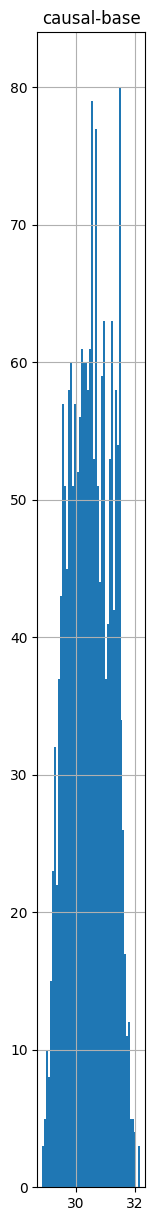

In [25]:
ncol = 3
nrow = int(np.ceil(graph.shape[1] / ncol))
print(ncol, nrow)
fig, axes = plt.subplots(nrow, ncol, figsize=(5 * nrow, 5 * ncol))
axes = axes.flatten()
print(fig, axes)
for i, ax in enumerate(axes):
    if i >= graph.shape[1]:
        ax.remove()
axes = axes[0:graph.shape[1]]

graph.hist(bins=50, ax=axes)

## Text

In [9]:
text = pd.DataFrame.from_dict({
    k : pd.Series(np.linalg.norm((data[k].trained_texts - data[k].comp_texts).numpy(), ord=2, axis=1), name=k)
    for k in files
})

In [10]:
text.describe()

,causal-base
count,5998.000000
mean,28.476700
std,0.163678
min,28.089605
25%,28.340743
50%,28.461645
75%,28.601416
max,28.851801


array([<Axes: title={'center': 'causal-base'}>], dtype=object)

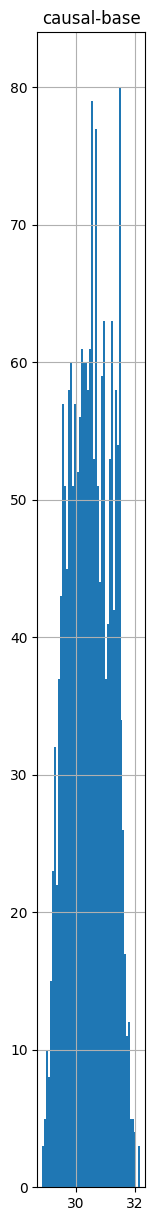

In [11]:
ncol = 3
nrow = int(np.ceil(text.shape[1] / ncol))

fig, axes = plt.subplots(nrow, ncol, figsize=(5 * nrow, 5 * ncol))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i >= text.shape[1]:
        ax.remove()
axes = axes[0:text.shape[1]]

graph.hist(bins=50, ax=axes)

# Inspect node clustering on whole dataset

In [12]:
trained_clusters = pd.DataFrame.from_dict({
    k : cl.AffinityPropagation(damping=0.9, max_iter=1000) \
          .fit(data[k].trained_nodes.detach().cpu().numpy().copy()) \
          .labels_
    for k in files
})

In [13]:
comp_clusters = pd.DataFrame.from_dict({
    k : cl.AffinityPropagation(damping=0.9, max_iter=1000) \
          .fit(data[k].comp_nodes.detach().cpu().numpy().copy()) \
          .labels_
    for k in files
})

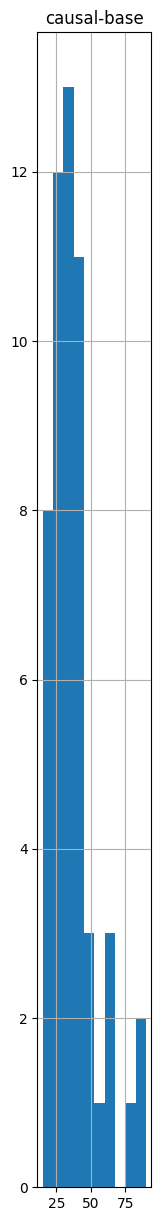

In [14]:
ncol = 3
nrow = int(np.ceil(len(files) / ncol))

fig, axes = plt.subplots(nrow, ncol, figsize=(5 * nrow, 5 * ncol))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i >= len(files):
        ax.remove()
axes = axes[0:text.shape[1]]

for col, ax in zip(files, axes):
    ax.set_title(col)
    trained_clusters[col].value_counts().hist(ax=ax)

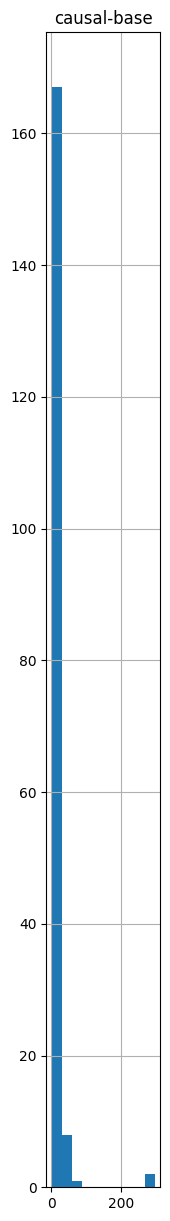

In [15]:
ncol = 3
nrow = int(np.ceil(len(files) / ncol))

fig, axes = plt.subplots(nrow, ncol, figsize=(5 * nrow, 5 * ncol))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i >= len(files):
        ax.remove()
axes = axes[0:text.shape[1]]

for col, ax in zip(files, axes):
    ax.set_title(col)
    comp_clusters[col].value_counts().hist(ax=ax)

In [16]:
node_clusters = node_data.copy()

for k in files:
    inds = data[k].dataset.graph_data.node_ids.numpy()
    
    node_clusters['trained_cluster_' + k.replace('-', '_')] = pd.Series(trained_clusters[k].tolist(), index=inds)
    node_clusters['comp_cluster_' + k.replace('-', '_')] = pd.Series(comp_clusters[k].tolist(), index=inds)

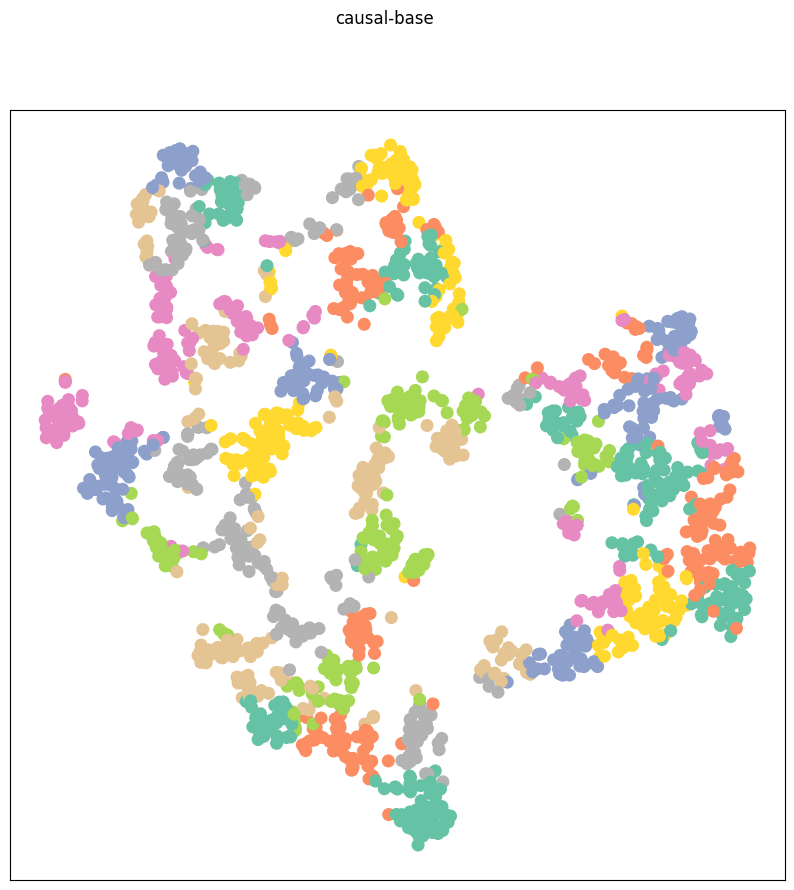

In [17]:
for k in files:
    ut.plot_embeddings(data[k].trained_nodes, trained_clusters[k], title=k)

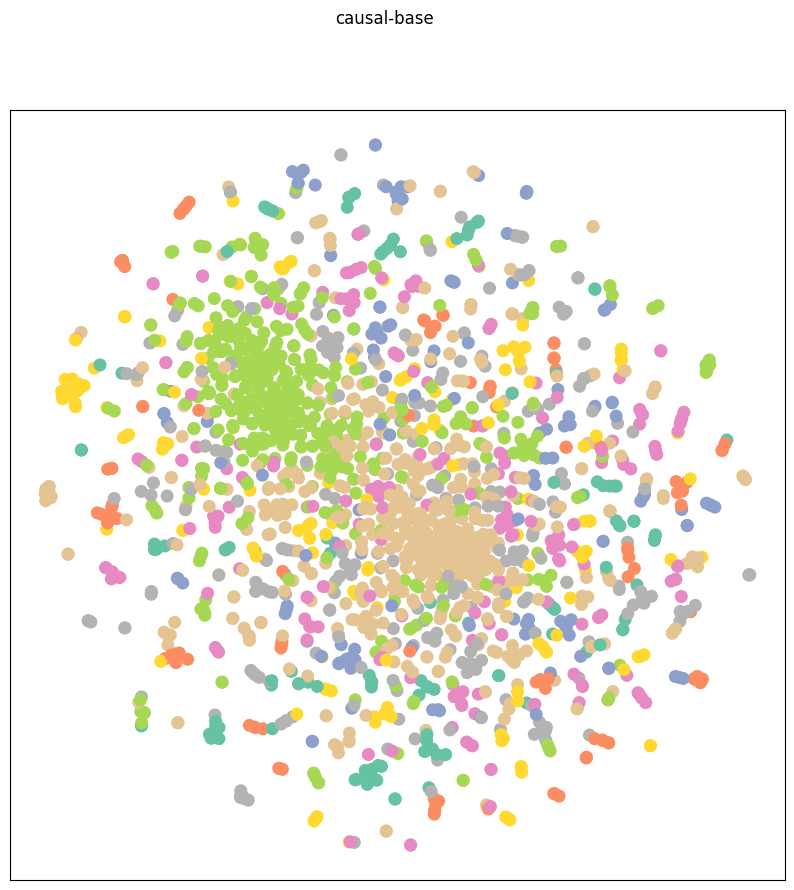

In [18]:
for k in files:
    ut.plot_embeddings(data[k].comp_nodes, comp_clusters[k], title=k)